Written by Bharath Ramsundar and Evan Feinberg

Copyright 2016, Stanford University


Computationally predicting molecular solubility through is useful for drug-discovery. In this tutorial, we will use the `deepchem` library to fit a simple statistical model that predicts the solubility of drug-like compounds. The process of fitting this model involves four steps:

1. Loading a chemical dataset, consisting of a series of compounds along with aqueous solubility measurements.
2. Transforming each compound into a feature vector $v \in \mathbb{R}^n$ comprehensible to statistical learning methods.
3. Fitting a simple model that maps feature vectors to estimates of aqueous solubility.
4. Visualizing the results.

We need to load a dataset of estimated aqueous solubility measurements [1] into deepchem. The data is in CSV format and contains SMILES strings, predicted aqueaous solubilities, and a number of extraneous (for our purposes) molecular properties. Here is an example line from the dataset:

|Compound ID|ESOL predicted log solubility in mols per litre|Minimum Degree|Molecular Weight|Number of H-Bond Donors|Number of Rings|Number of Rotatable Bonds|Polar Surface Area|measured log solubility in mols per litre|smiles|
|-----------|-----------------------------------------------|--------------|----------------|----------------------------|---------------|-------------------------|-----------------------------------------------------------------------|------|
|benzothiazole|-2.733|2|135.191|0|2|0|12.89|-1.5|c2ccc1scnc1c2|

Most of these fields are not useful for our purposes. The two fields that we will need are the "smiles" field and the "measured log solubility in mols per litre". The "smiles" field holds a SMILES string [2] that specifies the compound in question. Before we load this data into deepchem, we will load the data into python and do some simple preliminary analysis to gain some intuition for the dataset. 

In [1]:
%autoreload 2
%pdb off
from deepchem.utils.save import load_from_disk

dataset_file= "../datasets/delaney-processed.csv"
dataset = load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

Automatic pdb calling has been turned OFF
Columns of dataset: ['Compound ID' 'ESOL predicted log solubility in mols per litre'
 'Minimum Degree' 'Molecular Weight' 'Number of H-Bond Donors'
 'Number of Rings' 'Number of Rotatable Bonds' 'Polar Surface Area'
 'measured log solubility in mols per litre' 'smiles']
Number of examples in dataset: 1128


To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started.

In [2]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, HTML, display

def display_images(filenames):
    """Helper to pretty-print images."""
    imagesList=''.join(
        ["<img style='width: 140px; margin: 0px; float: left; border: 1px solid black;' src='%s' />"
         % str(s) for s in sorted(filenames)])
    display(HTML(imagesList))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

Now, we display some compounds from the dataset:

In [3]:
num_to_display = 14
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))
display_images(mols_to_pngs(molecules))

Analyzing the distribution of solubilities shows us a nice spread of data.

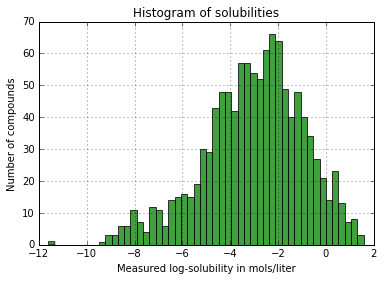

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

solubilities = np.array(dataset["measured log solubility in mols per litre"])
n, bins, patches = plt.hist(solubilities, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of solubilities')
plt.grid(True)
plt.show()


With our preliminary analysis completed, we return to the original goal of constructing a predictive statistical model of molecular solubility using `deepchem`. The first step in creating such a molecule is translating each compound into a vectorial format that can be understood by statistical learning techniques. This process is commonly called featurization. `deepchem` packages a number of commonly used featurization for user convenience. In this tutorial, we will use ECPF4 fingeprints [3].

`deepchem` offers an object-oriented API for featurization. To get started with featurization, we first construct a ```Featurizer``` object. `deepchem` provides the ```CircularFingeprint``` class (a subclass of ```Featurizer``` that performs ECFP4 featurization).


In [5]:
from deepchem.featurizers.fingerprints import CircularFingerprint

featurizers = [CircularFingerprint(size=1024)]

Now, let's perform the actual featurization. `deepchem` provides the ```DataFeaturizer``` class for this purpose. The ```featurize()``` method for this class loads data from disk and uses provided ```Featurizer```instances to transform the provided data into feature vectors. The method constructs an instance of class ```FeaturizedSamples``` that has useful methods, such as an iterator, over the featurized data.

In [6]:
import tempfile, shutil
from deepchem.featurizers.featurize import DataFeaturizer

#Make directories to store the raw and featurized datasets.
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

featurizer = DataFeaturizer(tasks=["measured log solubility in mols per litre"],
                            smiles_field="smiles",
                            compound_featurizers=featurizers)
featurized_samples = featurizer.featurize(dataset_file, feature_dir, samples_dir)

When constructing statistical models, it's necessary to separate the provided data into train/test subsets. The train subset is used to learn the statistical model, while the test subset is used to evaluate the learned model. In practice, it's often useful to elaborate this split further and perform a train/validation/test split. The validation set is used to perform model selection. Proposed models are evaluated on the validation-set, and the best performed model is at the end tested on the test-set.

Choosing the proper method of performing a train/validation/test split can be challenging. Standard machine learning practice is to perform a random split of the data into train/validation/test, but random splits are not well suited for the purposes of chemical informatics. For our predictive models to be useful, we require them to have predictive power in portions of chemical space beyond the set of molecules in the training data. Consequently, our models should use splits of the data that separate compounds in the training set from those in the validation and test-sets. We use Bemis-Murcko scaffolds [5] to perform this separation (all compounds that share an underlying molecular scaffold will be placed into the same split in the train/test/validation split).


In [ ]:
splittype = "scaffold"
train_dir = tempfile.mkdtemp()
valid_dir = tempfile.mkdtemp()
test_dir = tempfile.mkdtemp()

train_samples, valid_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, valid_dir, test_dir)

Let's visually inspect some of the molecules in the separate splits to verify that they appear structurally dissimilar. The `FeaturizedSamples` class provides an `itersamples` method that lets us obtain the underlying compounds in each split.

In [8]:
train_mols = [Chem.MolFromSmiles(str(compound["smiles"]))
              for compound in islice(train_samples.itersamples(), num_to_display)]
display_images(mols_to_pngs(train_mols, basename="train"))

In [9]:
valid_mols = [Chem.MolFromSmiles(str(compound["smiles"]))
              for compound in islice(valid_samples.itersamples(), num_to_display)]
display_images(mols_to_pngs(valid_mols, basename="valid"))

Notice the visual distinction between the train/validation splits. The most-common scaffolds are reserved for the train split, with the rarer scaffolds allotted to validation/test.

To perform machine learning upon these datasets, we need to convert the samples into datasets suitable for machine-learning (that is, into data matrix $X \in \mathbb{R}^{n\times d}$ where $n$ is the number of samples and $d$ the dimensionality of the feature vector, and into label vector $y \in \mathbb{R}^n$). `deepchem` provides the `Dataset` class to facilitate this transformation. We simply need to instantiate separate instances of the Dataset() class, one corresponding to each split of the data. This style lends itself easily to validation-set hyperparameter searches, which we illustate below.

In [1]:
from deepchem.utils.dataset import Dataset
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=featurizers, tasks=["measured log solubility in mols per litre"])
valid_dataset = Dataset(data_dir=valid_dir, samples=valid_samples, 
                        featurizers=featurizers, tasks=["measured log solubility in mols per litre"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=featurizers, tasks=["measured log solubility in mols per litre"])


NameError: name 'train_dir' is not defined

> <ipython-input-1-077d9c2ad380>(2)<module>()
      1 from deepchem.utils.dataset import Dataset
----> 2 train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
      3                         featurizers=featurizers, tasks=["measured log solubility in mols per litre"])
      4 valid_dataset = Dataset(data_dir=valid_dir, samples=valid_samples, 
      5                         featurizers=featurizers, tasks=["measured log solubility in mols per litre"])

ipdb> exit


The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data. One common transformation applied to data is to normalize it to have zero-mean and unit-standard-deviation. We will apply this transformation to the log-solubility (as seen above, the log-solubility ranges from -12 to 2).

In [11]:
from deepchem.transformers import NormalizationTransformer

input_transformers = []
output_transformers = [NormalizationTransformer(transform_y=True, dataset=train_dataset)]
transformers = input_transformers + output_transformers
for transformer in transformers:
    transformer.transform(train_dataset)
for transformer in transformers:
    transformer.transform(valid_dataset)
for transformer in transformers:
    transformer.transform(test_dataset)

The next step after processing the data is to start fitting simple learning models to our data. `deepchem` provides a number of machine-learning model classes.

In particular, `deepchem` provides a convenience class, ```SklearnModel``` that wraps any machine-learning model available in scikit-learn [6]. Consequently, we will start by building a simple random-forest regressor that attempts to predict the log-solubility from our computed ECFP4 features. To train the model, we instantiate the ```SklearnModel``` object, then call the ```fit()``` method on the ```train_dataset``` we constructed above. We then save the model to disk.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from deepchem.models.standard import SklearnModel

model_dir = tempfile.mkdtemp()
task_types = {"measured log solubility in mols per litre": "regression"}
model_params = {"data_shape": train_dataset.get_data_shape()}
model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor())
model.fit(train_dataset)
model.save(model_dir)
shutil.rmtree(model_dir)


We next evaluate the model on the validation set to see its predictive power. `deepchem` provides the `Evaluator` class to facilitate this process. To evaluate the constructed `model` object, create a new `Evaluator` instance and call the `compute_model_performance()` method.

In [13]:
from deepchem.utils.evaluate import Evaluator
valid_csv_out = tempfile.NamedTemporaryFile()
valid_stats_out = tempfile.NamedTemporaryFile()

evaluator = Evaluator(model, valid_dataset, output_transformers)
df, r2score = evaluator.compute_model_performance(
    valid_csv_out, valid_stats_out)
print(r2score)


                                   task_name  r2_score  rms_error
0  measured log solubility in mols per litre  0.065904   1.959901


The performance of this basic random-forest model isn't very strong. To construct stronger models, let's attempt to optimize the hyperparameters (choices made in the model-specification) to achieve better performance. For random forests, we can tweak `n_estimators` which controls the number of trees in the forest, and `max_features` which controls the number of features to consider when performing a split. We now build a series of `SklearnModel`s with different choices for `n_estimators` and `max_features` and evaluate performance on the validation set.

In [14]:
import itertools

n_estimators_list = [100]
max_features_list = ["auto", "sqrt", "log2", None]
hyperparameters = [n_estimators_list, max_features_list]
best_validation_score = -np.inf
best_hyperparams = None
best_model, best_model_dir = None, None
for hyperparameter_tuple in itertools.product(*hyperparameters):
    n_estimators, max_features = hyperparameter_tuple
    
    model_dir = tempfile.mkdtemp()
    model = SklearnModel(
        task_types, model_params,
        model_instance=RandomForestRegressor(n_estimators=n_estimators,
                                             max_features=max_features))
    model.fit(train_dataset)
    model.save(model_dir)
    
    evaluator = Evaluator(model, valid_dataset, output_transformers)
    df, r2score = evaluator.compute_model_performance(
        valid_csv_out, valid_stats_out)
    valid_r2_score = r2score.iloc[0]["r2_score"]
    print("n_estimators %d, max_features %s => Validation set R^2 %f" %
          (n_estimators, str(max_features), valid_r2_score))
    if valid_r2_score > best_validation_score:
        best_validation_score = valid_r2_score
        best_hyperparams = hyperparameter_tuple
        if best_model_dir is not None:
            shutil.rmtree(best_model_dir)
        best_model_dir = model_dir
        best_model = model
    else:
        shutil.rmtree(model_dir)

print("Best hyperparameters: %s" % str(best_hyperparams))
best_rf_hyperparams = best_hyperparams
best_rf = best_model

n_estimators 100, max_features auto => Validation set R^2 0.147702
n_estimators 100, max_features sqrt => Validation set R^2 0.315835
n_estimators 100, max_features log2 => Validation set R^2 0.291192
n_estimators 100, max_features None => Validation set R^2 0.149424
Best hyperparameters: (100, 'sqrt')


The best model achieves significantly higher $R^2$ on the validation set than the first model we constructed. Now, let's perform the same sort of hyperparameter search, but with a simple deep-network instead.

In [15]:
from deepchem.models.deep import SingleTaskDNN
import numpy.random

model_params = {"activation": "relu",
                "dropout": 0.5,
                "momentum": .9, "nesterov": True,
                "decay": 1e-4, "batch_size": 5,
                "nb_epoch": 10,
                "init": "glorot_uniform",
                "data_shape": train_dataset.get_data_shape()}

lr_list = np.power(10., np.random.uniform(-5, -1, size=1))
nb_hidden_list = [100]
nb_epoch_list = [10]
nesterov_list = [False]
dropout_list = [.25]
nb_layers_list = [1]
batchnorm_list = [False]
hyperparameters = [lr_list, nb_layers_list, nb_hidden_list, nb_epoch_list, nesterov_list, dropout_list, batchnorm_list]
best_validation_score = -np.inf
best_hyperparams = None
best_model, best_model_dir = None, None
for hyperparameter_tuple in itertools.product(*hyperparameters):
    print("Testing %s" % str(hyperparameter_tuple))
    lr, nb_layers, nb_hidden, nb_epoch, nesterov, dropout, batchnorm = hyperparameter_tuple
    model_params["nb_hidden"] = nb_hidden
    model_params["nb_layers"] = nb_layers
    model_params["learning_rate"] = lr
    model_params["nb_epoch"] = nb_epoch
    model_params["nesterov"] = nesterov
    model_params["dropout"] = dropout
    model_params["batchnorm"] = batchnorm
    model_dir = tempfile.mkdtemp()
    model = SingleTaskDNN(task_types, model_params)
    model.fit(train_dataset)
    model.save(model_dir)
    
    evaluator = Evaluator(model, valid_dataset, output_transformers)
    df, r2score = evaluator.compute_model_performance(
        valid_csv_out, valid_stats_out)
    valid_r2_score = r2score.iloc[0]["r2_score"]
    print("learning_rate %f, nb_hidden %d, nb_epoch %d, nesterov %s, dropout %f => Validation set R^2 %f" %
          (lr, nb_hidden, nb_epoch, str(nesterov), dropout, valid_r2_score))
    if valid_r2_score > best_validation_score:
        best_validation_score = valid_r2_score
        best_hyperparams = hyperparameter_tuple
        if best_model_dir is not None:
            shutil.rmtree(best_model_dir)
        best_model_dir = model_dir
        best_model = model
    else:
        shutil.rmtree(model_dir)

print("Best hyperparameters: %s" % str(best_hyperparams))
print("best_validation_score: %f" % best_validation_score)
best_dnn = best_model

Using Theano backend.
/home/rbharath/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Testing (0.00047657408368705328, 1, 100, 10, False, 0.25, False)


KeyboardInterrupt: 

Now that we have a reasonable choice of hyperparameters, let's evaluate the performance of our best models on the test-set.

In [16]:
rf_test_csv_out = tempfile.NamedTemporaryFile()
rf_test_stats_out = tempfile.NamedTemporaryFile()
rf_test_evaluator = Evaluator(best_rf, test_dataset, output_transformers)
rf_test_df, rf_test_r2score = rf_test_evaluator.compute_model_performance(
    rf_test_csv_out, rf_test_stats_out)
rf_test_r2_score = rf_test_r2score.iloc[0]["r2_score"]
print("RF Test set R^2 %f" % (rf_test_r2_score))

RF Test set R^2 0.307424


In [26]:
dnn_test_csv_out = tempfile.NamedTemporaryFile()
dnn_test_stats_out = tempfile.NamedTemporaryFile()
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, output_transformers)
dnn_test_df, dnn_test_r2score = dnn_test_evaluator.compute_model_performance(
    dnn_test_csv_out, dnn_test_stats_out)
dnn_test_r2_score = dnn_test_r2score.iloc[0]["r2_score"]
print("DNN Test set R^2 %f" % (dnn_test_r2_score))

DNN Test set R^2 -0.104868


Now, let's plot the predicted $R^2$ scores versus the true $R^2$ scores for the constructed model.

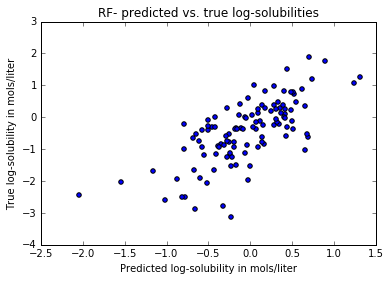

In [17]:
task = "measured log solubility in mols per litre"
rf_predicted_test = np.array(rf_test_df[task + "_pred"])
rf_true_test = np.array(rf_test_df[task])
plt.scatter(rf_predicted_test, rf_true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'RF- predicted vs. true log-solubilities')
plt.show()

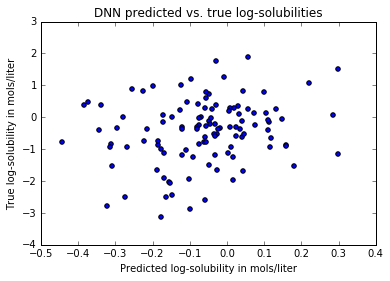

In [29]:
task = "measured log solubility in mols per litre"
predicted_test = np.array(dnn_test_df[task + "_pred"])
true_test = np.array(dnn_test_df[task])
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'DNN predicted vs. true log-solubilities')
plt.show()

[1] John S. Delaney. ESOL: Estimating aqueous solubility directly from molecular structure. Journal
of Chemical Information and Computer Sciences, 44(3):1000–1005, 2004.

[2] Anderson, Eric, Gilman D. Veith, and David Weininger. SMILES, a line notation and computerized
interpreter for chemical structures. US Environmental Protection Agency, Environmental Research Laboratory, 1987.

[3] Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." Journal of chemical information
and modeling 50.5 (2010): 742-754.
    
[4] Van Der Walt, Stefan, S. Chris Colbert, and Gael Varoquaux.
"The NumPy array:a structure for efficient numerical computation." Computing in Science & Engineering 13.2 (2011): 22-30.
    
[5] Bemis, Guy W., and Mark A. Murcko. "The properties of known drugs. 1. Molecular frameworks."
Journal of medicinal chemistry 39.15 (1996): 2887-2893.

[6] Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." The Journal of Machine Learning Research 12 (2011): 2825-2830.